#### **Importing the Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, ConfusionMatrixDisplay,
                             f1_score, recall_score, precision_score)
from imblearn.over_sampling import SMOTE
import xgboost as xgb

#### **Importing the file**

In [5]:
df_2009 = pd.read_excel(r"C:\Users\Dell\Documents\online_retail_II.xlsx\online_retail_II.xlsx", sheet_name="Year 2009-2010")
df_2010 = pd.read_excel(r"C:\Users\Dell\Documents\online_retail_II.xlsx\online_retail_II.xlsx", sheet_name="Year 2010-2011")

# Combine both
df = pd.concat([df_2009, df_2010], ignore_index=True)

print(df.shape)

(1067371, 8)


#### **Data Cleaning**

In [6]:
df.duplicated().sum()

np.int64(34335)

In [7]:
df = df.drop_duplicates()

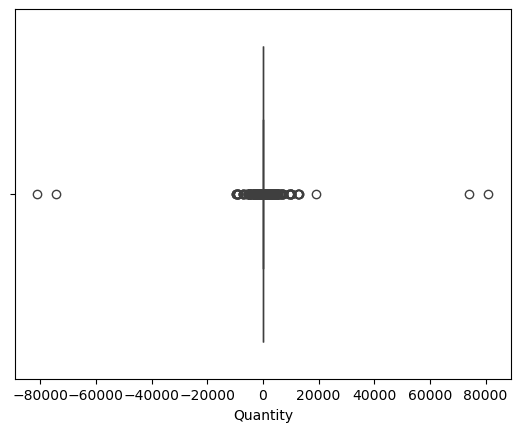

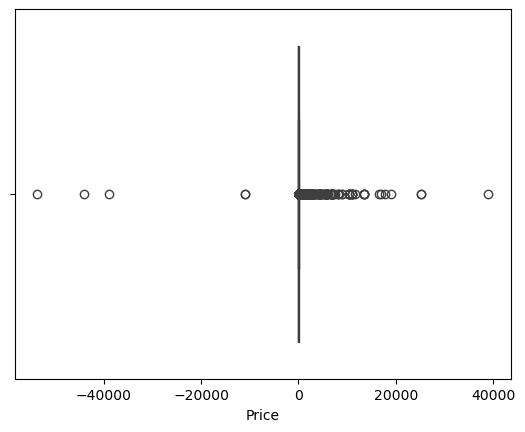

In [9]:
import seaborn as sns
sns.boxplot(x=df["Quantity"])
plt.show()

sns.boxplot(x=df["Price"])
plt.show()

In [10]:
df = df.dropna(subset=["Customer ID"])

In [11]:
df = df[~df["Invoice"].astype(str).str.startswith("C")]

In [12]:
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

#### **Removing the anomaly**

In [13]:
df = df[~((df["Customer ID"] == 16446) & (df["Quantity"] > 50000))]

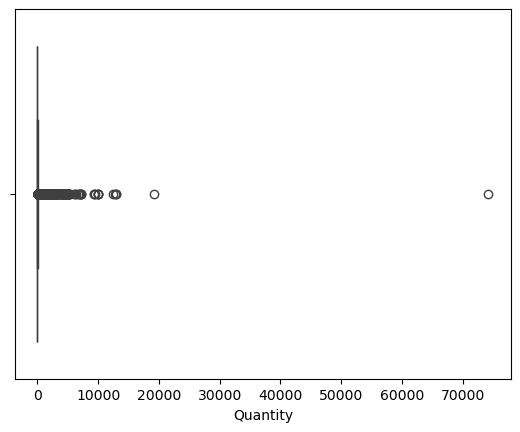

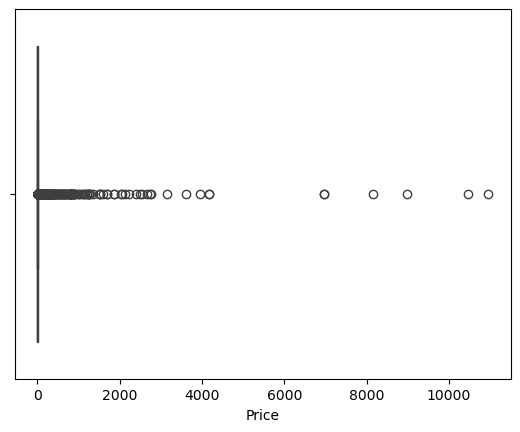

In [14]:
sns.boxplot(x=df["Quantity"])
plt.show()

sns.boxplot(x=df["Price"])
plt.show()

In [15]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice']  = df['Quantity'] * df['Price']

print("Dataset shape:", df.shape)

Dataset shape: (779424, 9)


#### **Snapshot Date as a reference point for caluclating recency later**

In [16]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

#### **Building RFM Features**

In [17]:
rfm = df.groupby('Customer ID').agg(
    Recency   = ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('Invoice',     'nunique'),
    Monetary  = ('TotalPrice',  'sum'),
).reset_index()

In [18]:
extra = df.groupby('Customer ID').agg(
    AvgOrderValue  = ('TotalPrice', 'mean'),
    UniqueProducts = ('StockCode',  'nunique'),
).reset_index()

In [19]:
customer_df = rfm.merge(extra, on='Customer ID')
print("Features ready. Customers:", len(customer_df))

Features ready. Customers: 5878


#### **Defining Churn label**

In [20]:
CHURN_DAYS = 90
customer_df['Churned'] = (customer_df['Recency'] > CHURN_DAYS).astype(int)

print(f"\nChurn rate: {customer_df['Churned'].mean():.1%}")
print(customer_df['Churned'].value_counts().rename({0: 'Active', 1: 'Churned'}))


Churn rate: 50.9%
Churned
Churned    2990
Active     2888
Name: count, dtype: int64


#### **Train/Test Stage**

In [58]:
from sklearn.model_selection import train_test_split

feature_cols = ['Frequency','Monetary','AvgOrderValue','UniqueProducts']

X = customer_df[feature_cols].fillna(0)
y = customer_df['Churned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y        
)

#### **SMOTE For balancing and Scaling for Logistic R**

In [59]:
smote            = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

scaler           = StandardScaler()
X_train_scaled   = scaler.fit_transform(X_train_bal)
X_test_scaled    = scaler.transform(X_test)

print(f"After SMOTE — Churned: {y_train_bal.sum()} | Active: {(y_train_bal==0).sum()}")

After SMOTE — Churned: 2392 | Active: 2392


#### **Training the models**

In [60]:
scale_pos = (y_train_bal == 0).sum() / y_train_bal.sum()

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest':       RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost':             xgb.XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.05,
                                              scale_pos_weight=scale_pos, eval_metric='logloss',
                                              random_state=42),
}

# Logistic Regression uses scaled data; tree models use unscaled
X_train_map = {'Logistic Regression': X_train_scaled,
               'Random Forest': X_train_bal, 'XGBoost': X_train_bal}
X_test_map  = {'Logistic Regression': X_test_scaled,
               'Random Forest': X_test,      'XGBoost': X_test}

for name, model in models.items():
    model.fit(X_train_map[name], y_train_bal)

print("\nAll 3 models trained.")


All 3 models trained.


#### **Model Evaluation**

In [61]:
print("\n" + "="*55)
print("MODEL EVALUATION (Default Threshold = 0.50)")
print("="*55)

summary = []
for name, model in models.items():
    y_pred = model.predict(X_test_map[name])
    y_prob = model.predict_proba(X_test_map[name])[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)
    summary.append({
    'Model':     name,
    'Precision': round(report.get('1', {}).get('precision', 0), 3),
    'Recall':    round(report.get('1', {}).get('recall',    0), 3),
    'F1':        round(report.get('1', {}).get('f1-score',  0), 3),
    'ROC-AUC':   round(roc_auc_score(y_test, y_prob), 3),
})
    print(f"\n{name}")
    print(classification_report(y_test, y_pred, target_names=['Active','Churned']))

print("\n--- Summary ---")
print(pd.DataFrame(summary).to_string(index=False))



MODEL EVALUATION (Default Threshold = 0.50)

Logistic Regression
              precision    recall  f1-score   support

      Active       0.78      0.59      0.67       578
     Churned       0.68      0.84      0.75       598

    accuracy                           0.72      1176
   macro avg       0.73      0.71      0.71      1176
weighted avg       0.73      0.72      0.71      1176


Random Forest
              precision    recall  f1-score   support

      Active       0.68      0.67      0.67       578
     Churned       0.68      0.69      0.69       598

    accuracy                           0.68      1176
   macro avg       0.68      0.68      0.68      1176
weighted avg       0.68      0.68      0.68      1176


XGBoost
              precision    recall  f1-score   support

      Active       0.76      0.66      0.71       578
     Churned       0.71      0.80      0.75       598

    accuracy                           0.73      1176
   macro avg       0.74      0.73     

#### **Threshold Tuning on xgboost trained model**

In [62]:
print("\n" + "="*55)
print("THRESHOLD TUNING — XGBoost")
print("="*55)

xgb_probs  = models['XGBoost'].predict_proba(X_test)[:, 1]
thresholds  = np.arange(0.10, 0.91, 0.05)
thresh_rows = []

for t in thresholds:
    y_pred_t = (xgb_probs >= t).astype(int)
    thresh_rows.append({
        'Threshold': round(t, 2),
        'Precision': round(precision_score(y_test, y_pred_t, zero_division=0), 3),
        'Recall':    round(recall_score(y_test,    y_pred_t, zero_division=0), 3),
        'F1':        round(f1_score(y_test,         y_pred_t, zero_division=0), 3),
    })

thresh_df    = pd.DataFrame(thresh_rows)
best_row     = thresh_df.loc[thresh_df['F1'].idxmax()]
best_thresh  = best_row['Threshold']

print(thresh_df.to_string(index=False))



THRESHOLD TUNING — XGBoost
 Threshold  Precision  Recall    F1
      0.10      0.553   0.988 0.709
      0.15      0.569   0.978 0.720
      0.20      0.589   0.965 0.732
      0.25      0.606   0.945 0.739
      0.30      0.620   0.923 0.742
      0.35      0.631   0.905 0.744
      0.40      0.651   0.876 0.747
      0.45      0.674   0.828 0.743
      0.50      0.711   0.799 0.753
      0.55      0.734   0.731 0.733
      0.60      0.764   0.639 0.696
      0.65      0.787   0.518 0.625
      0.70      0.802   0.380 0.515
      0.75      0.817   0.254 0.388
      0.80      0.844   0.109 0.193
      0.85      0.833   0.033 0.064
      0.90      0.750   0.015 0.030


#### **Plot showing the different metrics for different Thresholds**

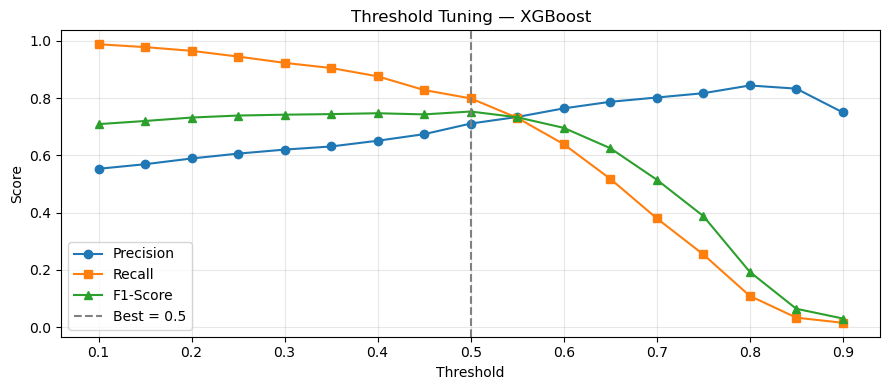

In [63]:
plt.figure(figsize=(9, 4))
plt.plot(thresh_df['Threshold'], thresh_df['Precision'], marker='o', label='Precision')
plt.plot(thresh_df['Threshold'], thresh_df['Recall'],    marker='s', label='Recall')
plt.plot(thresh_df['Threshold'], thresh_df['F1'],        marker='^', label='F1-Score')
plt.axvline(x=best_thresh, linestyle='--', color='gray', label=f'Best = {best_thresh}')
plt.title('Threshold Tuning — XGBoost')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### **Hyperparameter Tuning (Grid Search CV)**

In [64]:
print("\n" + "="*55)
print("HYPERPARAMETER TUNING — GridSearchCV")
print("="*55)

param_grid = {
    'n_estimators':     [100, 200, 300],
    'max_depth':        [3, 4, 6],
    'learning_rate':    [0.01, 0.05, 0.1],
    'subsample':        [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
}

base_xgb = xgb.XGBClassifier(
    scale_pos_weight=scale_pos,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
)

grid_search = GridSearchCV(
    estimator=base_xgb,
    param_grid=param_grid,
    scoring='recall',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    refit=True,
)

print("Running GridSearchCV... (may take a few minutes)")
grid_search.fit(X_train_bal, y_train_bal)

print(f"\n✅ Best Parameters:")
for k, v in grid_search.best_params_.items():
    print(f"   {k}: {v}")
print(f"   Best CV Recall: {grid_search.best_score_:.4f}")



HYPERPARAMETER TUNING — GridSearchCV
Running GridSearchCV... (may take a few minutes)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Best Parameters:
   colsample_bytree: 0.9
   learning_rate: 0.01
   max_depth: 4
   n_estimators: 100
   subsample: 0.9
   Best CV Recall: 0.7558


#### **Comparing the Base xgboost (Threshold = 0.35) vs Hyper-tuned xgboost model (Threshold = 0.4)**

In [68]:
print("\n" + "="*55)
print("FINAL COMPARISON")
print("="*55)

tuned_xgb   = grid_search.best_estimator_
y_prob_tuned = tuned_xgb.predict_proba(X_test)[:, 1]

tuned_thresh_rows = []
for t in thresholds:
    y_pred_t = (y_prob_tuned >= t).astype(int)
    tuned_thresh_rows.append({
        'Threshold': round(t, 2),
        'F1':        round(f1_score(y_test, y_pred_t, zero_division=0), 3),
    })
tuned_thresh_df   = pd.DataFrame(tuned_thresh_rows)
best_tuned_thresh = tuned_thresh_df.loc[tuned_thresh_df['F1'].idxmax(), 'Threshold']

y_pred_baseline = (xgb_probs   >= 0.35).astype(int)
y_pred_tuned    = (y_prob_tuned >= 0.4).astype(int)

b = classification_report(y_test, y_pred_baseline, output_dict=True)['1']
t = classification_report(y_test, y_pred_tuned,    output_dict=True)['1']

comparison = pd.DataFrame({
    'Metric':                     ['Precision','Recall','F1','ROC-AUC'],
    f'Baseline (thresh= 0.35)': [
        round(b['precision'], 3), round(b['recall'], 3),
        round(b['f1-score'],  3), round(roc_auc_score(y_test, xgb_probs),    3)],
    f'Tuned (thresh= 0.4)': [
        round(t['precision'], 3), round(t['recall'], 3),
        round(t['f1-score'],  3), round(roc_auc_score(y_test, y_prob_tuned), 3)],
})
print(comparison.to_string(index=False))



FINAL COMPARISON
   Metric  Baseline (thresh= 0.35)  Tuned (thresh= 0.4)
Precision                    0.631                0.631
   Recall                    0.905                0.916
       F1                    0.744                0.747
  ROC-AUC                    0.790                0.793


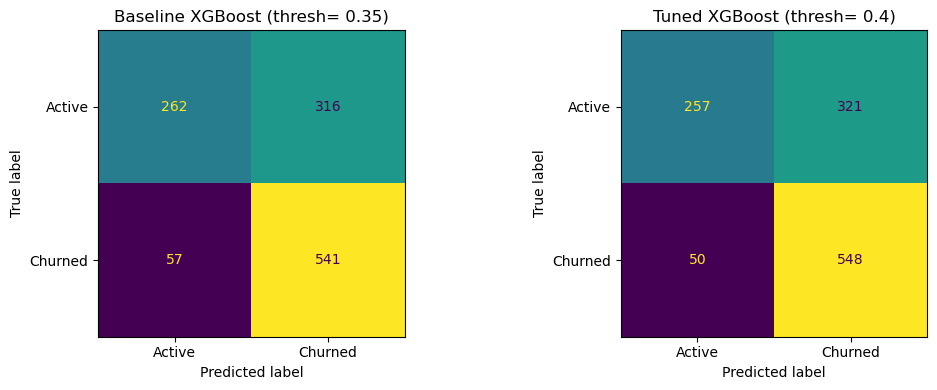

In [70]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_baseline),
    display_labels=['Active','Churned']).plot(ax=axes[0], colorbar=False)
axes[0].set_title(f'Baseline XGBoost (thresh= 0.35)')

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tuned),
    display_labels=['Active','Churned']).plot(ax=axes[1], colorbar=False)
axes[1].set_title(f'Tuned XGBoost (thresh= 0.4)')

plt.tight_layout()
plt.savefig('final_comparison.png', dpi=150)
plt.show()


### **Final Model**

In [73]:
chosen_threshold = 0.4
y_prob_final     = tuned_xgb.predict_proba(X_test)[:, 1]
y_pred_final     = (y_prob_final >= chosen_threshold).astype(int)

precision = precision_score(y_test, y_pred_final, zero_division=0)
recall    = recall_score(y_test,    y_pred_final, zero_division=0)
f1        = f1_score(y_test,        y_pred_final, zero_division=0)
roc_auc   = roc_auc_score(y_test,   y_prob_final)

print("=" * 50)
print(" Final Model: Tuned XGBoost @ Threshold 0.4")
print("=" * 50)
print(f"  Precision : {precision:.4f}")
print(f"  Recall    : {recall:.4f}")
print(f"  F1-Score  : {f1:.4f}")
print(f"  ROC-AUC   : {roc_auc:.4f}")
print("=" * 50)

 Final Model: Tuned XGBoost @ Threshold 0.4
  Precision : 0.6306
  Recall    : 0.9164
  F1-Score  : 0.7471
  ROC-AUC   : 0.7931


### **Conclusion** - 
This project successfully built a customer churn prediction system using the Online Retail II dataset. After thorough data cleaning and RFM-based feature engineering, three machine learning models were trained and evaluated. **XGBoost** emerged as the best-performing model, and through **threshold tuning** and **GridSearchCV hyperparameter** optimization, the final Tuned XGBoost model at **threshold** **0.40** achieved a **strong Recall** of **91.6%** and **ROC-AUC** of **0.793** — meaning the model correctly identifies over 9 out of 10 customers at risk of churning. This **high recall** is **critical** in a business context, as **catching potential churners early allows companies to take proactive retention actions and minimize revenue loss**.